## Notebook for testing SAM pipeline

Using same setup as feature-splatting

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

import cv2

from nerfstudio.models.splatfacto import SplatfactoModel
from nerfstudio.utils.eval_utils import eval_setup

from ultralytics import SAM
from ultralytics.models.sam import SAM2VideoPredictor

sys.path.append('../../')

import environment.utils.plotting_utils as plot
import environment.utils.feature_utils as feat
import environment.utils.segmentation_utils as seg
import environment.utils.grounded_segmentation_utils as gseg
from environment.utils.utils import pytorch_gc

# Find config for our current model
load_config = Path('/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/feature-splatting/2025-06-18_174658/config.yml')

[Taichi] version 1.7.3, llvm 15.0.4, commit 5ec301be, linux, python 3.10.12


[I 06/26/25 19:17:03.606 228840] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout
/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.10/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.10/dist-packages/mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapp

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load model 

In [2]:
_, pipeline, _, _ = eval_setup(load_config, test_mode="inference")

assert isinstance(pipeline.model, SplatfactoModel)

# model: SplatfactoModel = pipeline.model

[18:06:00] use color only optimization with sigmoid activation                                         ]8;id=564658;file:///usr/local/lib/python3.10/dist-packages/nerfstudio/models/splatfacto.py\splatfacto.py]8;;\:]8;id=834751;file:///usr/local/lib/python3.10/dist-packages/nerfstudio/models/splatfacto.py#266\266]8;;\

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/feature-splatting/2025-06-18_174658/nerfstudio_models/step-0
00029999.ckpt

In [37]:
%load_ext autoreload
%autoreload 2

import cv2
from environment.utils import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
gerbils_video_path = Path('/workspace/fieldwork-data/gerbils/2020_07_20_10_16_08_629297_compressed_defished_shrink_cropped_0_28800_final.mp4')

video_seg = utils.cut_video(gerbils_video_path.as_posix(), 0, 10)

In [78]:
from ultralytics.models.sam import SAM2VideoPredictor

# Create SAM2VideoPredictor
overrides = dict(conf=0.25, task="segment", mode="predict", imgsz=1024, model="sam2_b.pt")
predictor = SAM2VideoPredictor(overrides=overrides)

In [87]:
video_path = './test.mp4'
frames, metadata = utils.sample_random_frames(video_path, 1)

Video info: 10 frames, 24.00 FPS, 900x700


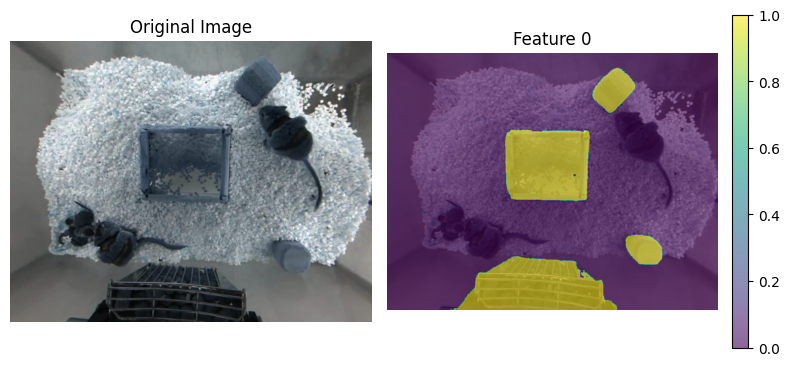

In [31]:
frame = results[9]
fig = plot.plot_features_over_image(frame.orig_img, frame.masks.data.sum(0).unsqueeze(0))

In [9]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
detector = gseg.load_grounding_dino_detector()
ram_model = gseg.load_ram_model('ram_plus', device=device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


--------------
/workspace/models/hub/models--xinyu1205--recognize-anything-plus-model/snapshots/84d4aee3a0265c4e0df1f714f0572011d1bf2ec3/ram_plus_swin_large_14m.pth
--------------
load checkpoint from /workspace/models/hub/models--xinyu1205--recognize-anything-plus-model/snapshots/84d4aee3a0265c4e0df1f714f0572011d1bf2ec3/ram_plus_swin_large_14m.pth
vit: swin_l


Use RAM w/ GroundedDINO to generate boxes

In [166]:
# Use RAM to automatically detect labels
image = video_seg[0]
labels = gseg.infer_ram_labels(image, ram_model, 384, device)

# Ensure labels end with period for better detection
labels = [label if label.endswith(".") else label + "." for label in labels]
print (labels)

detections = gseg.detect(image, detector=detector, labels=labels, threshold=0.1, postprocess=False)

boxes = [torch.tensor(result.box.xyxy) for result in detections]
boxes = torch.stack(boxes)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


['crate.', 'cart.', 'shopping.', 'toy.', 'floor.', 'cage.', 'blanket.', 'powder.', 'snowball.', 'animal.', 'snow.']


In [167]:
from ultralytics.models.sam import SAM2VideoPredictor

# Create SAM2VideoPredictor
overrides = dict(conf=0.25, task="segment", mode="predict", imgsz=1024, model="sam2.1_l.pt")
predictor = SAM2VideoPredictor(overrides=overrides)

results = predictor(source='test.mp4', stream=False, bboxes=boxes)


# fig = plot.plot_features_over_image(frame.orig_img, frame.masks.data.sum(0).unsqueeze(0))



Ultralytics 8.3.159 🚀 Python-3.10.12 torch-2.1.2+cu118 CUDA:0 (NVIDIA A40, 45515MiB)
100%|██████████| 428M/428M [00:06<00:00, 69.1MB/s] 

inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/10) /workspace/collab-environment/environment/notebooks/test.mp4: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1 30, 1 31, 1 32, 1 33, 1 34, 1 35, 1 36, 1 37, 1 38, 1 39, 1 40,

OutOfMemoryError: CUDA out of memory. Tried to allocate 19.08 GiB. GPU 0 has a total capacty of 44.45 GiB of which 12.36 GiB is free. Process 531380 has 32.08 GiB memory in use. Of the allocated memory 29.78 GiB is allocated by PyTorch, and 1.97 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

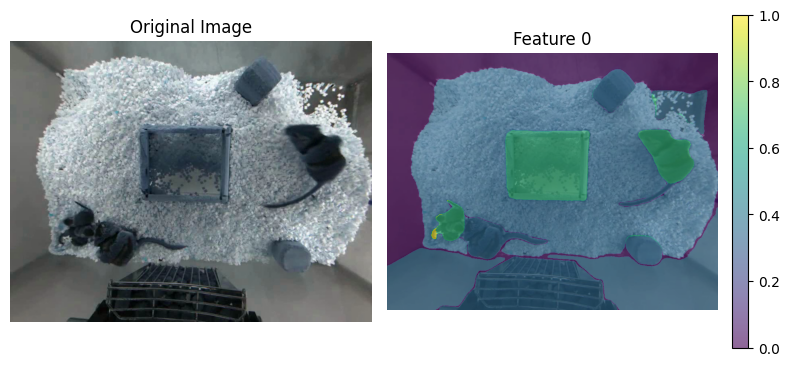

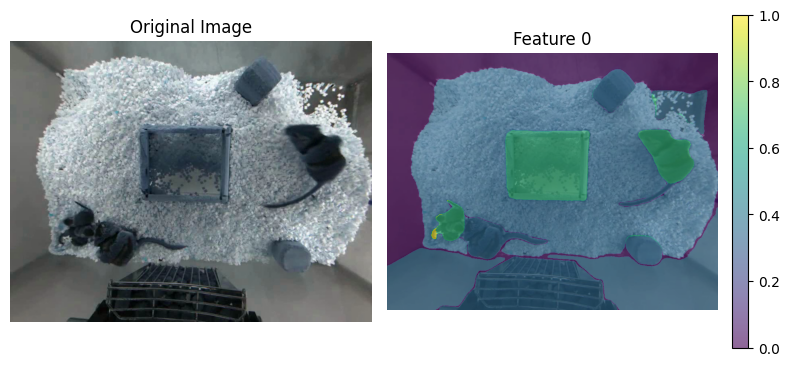

In [165]:
result = results[3]
plot.plot_features_over_image(result.orig_img, result.masks.data.sum(0).unsqueeze(0))

### Test accessing SAM model

In [4]:
image_paths = pipeline.datamanager.train_dataset.image_filenames

print (f"Total number of images: {len(image_paths)}")

Total number of images: 279


Load the following models:
1) SAM -- object segmentation
2) YOLO (objawaremodel) -- detection
3) SAM predictor -- calculate image embedding

In [5]:
# mobilesamv2, ObjAwareModel, predictor = load_mobile_sam(
clip_model = feat.load_clip_model()
mobilesamv2, ObjAwareModel, predictor = seg.load_mobile_sam()

Loading CLIP model with backbone: ViT-L/14@336px


Using cache found in /workspace/models/hub/RogerQi_MobileSAMV2_main
/workspace/models/hub/RogerQi_MobileSAMV2_main/mobilesamv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with mobilesamv2.tinyvit.tiny_vit.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/models/hub/RogerQi_MobileSAMV2_main/mobilesamv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with mobilesamv2.tinyvit.tiny_vit.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/models/hub/RogerQi_MobileSAMV2_main/mobilesamv2/tinyvit/tiny_vit.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with mobilesamv2.tinyvit.tiny_vit.tiny_vit_21m_224. This is because the name being registered conflicts with an existi

checkpoint_load_scucess


### Test running and segmenting a single image

Load image

In [108]:
image_file_path = str(image_paths[0])
image = cv2.imread(image_file_path)

NameError: name 'image_paths' is not defined

Extract features from a single image

In [14]:
clip_features, clip_feat_dim = feat.extract_clip_features(clip_model, image)

#### Auto-Segmented Masks

Create autosegmented masks and extract CLIP features w/in those masks

In [15]:
masks = seg.auto_segment_image(image, mobilesamv2)
features = feat.aggregate_samclip_features(clip_features, masks, obj_resolution=100, final_resolution=64)

Plot masks and features

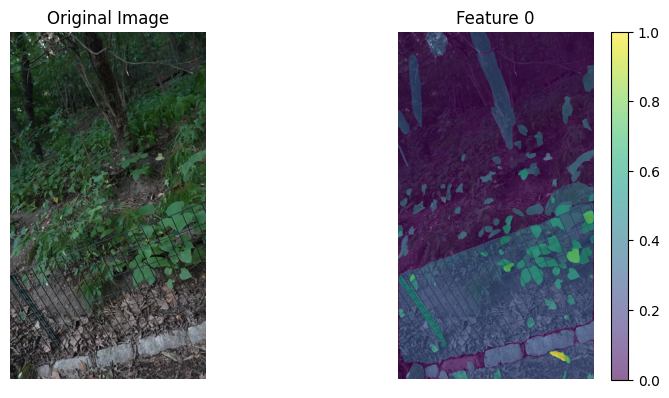

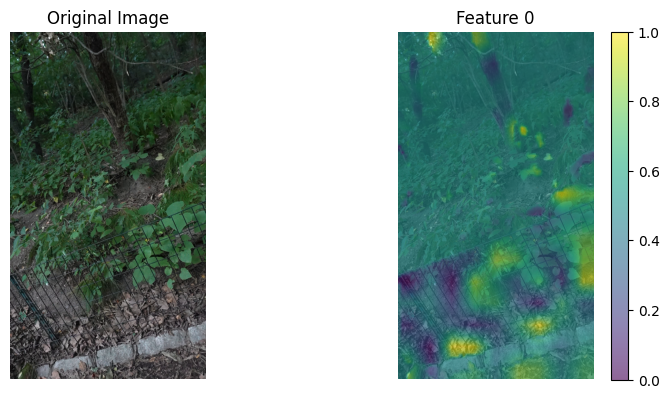

In [17]:
fig = plot.plot_features_over_image(image_file_path, masks.sum(0).unsqueeze(0))
fig = plot.plot_features_over_image(image_file_path, features.mean(0).unsqueeze(0))

#### YOLO Object-bounding masks

In [26]:
obj_results = seg.get_object_masks(image, ObjAwareModel)
masks = seg.object_segment_image(image, mobilesamv2, obj_results, predictor)



0: 1024x576 57 objects, 176.8ms
Speed: 5.2ms preprocess, 176.8ms inference, 3.2ms postprocess per image at shape (1, 3, 1024, 1024)


Perform SAMCLIP aggregation over object masks

In [28]:
# Aggregate mask-wise features
features = feat.aggregate_samclip_features(clip_features, masks, obj_resolution=100, final_resolution=64)

Plot mask over image

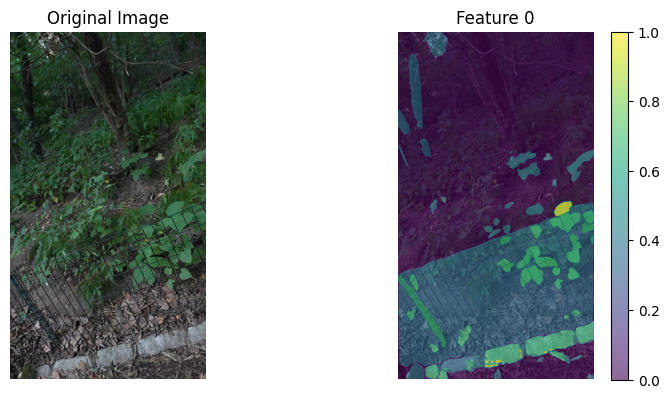

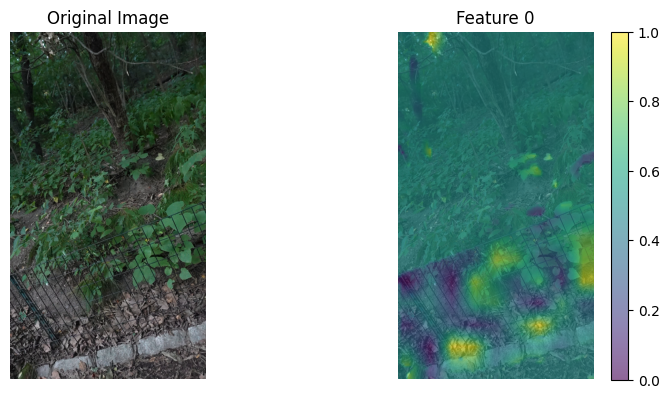

In [29]:
fig = plot.plot_features_over_image(image_file_path, masks.sum(0).unsqueeze(0))
fig = plot.plot_features_over_image(image_file_path, features.mean(0).unsqueeze(0))

## Compare to grounded dino

In [26]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
detector = gseg.load_grounding_dino_detector()
segmentor, processor = gseg.load_sam_segmenter()
ram_model = gseg.load_ram_model('ram_plus', device=device)



Device set to use cuda


--------------
/workspace/models/hub/models--xinyu1205--recognize-anything-plus-model/snapshots/84d4aee3a0265c4e0df1f714f0572011d1bf2ec3/ram_plus_swin_large_14m.pth
--------------
load checkpoint from /workspace/models/hub/models--xinyu1205--recognize-anything-plus-model/snapshots/84d4aee3a0265c4e0df1f714f0572011d1bf2ec3/ram_plus_swin_large_14m.pth
vit: swin_l


In [ ]:
# Use RAM to automatically detect labels
labels = gseg.infer_ram_labels(image, ram_model, 384, device)



In [56]:
# Ensure labels end with period for better detection
labels = [label if label.endswith(".") else label + "." for label in labels]

results = gseg.detect(image, detector=detector, labels=labels, threshold=0.)

## Test gerbils data

In [34]:
%load_ext autoreload
%autoreload 2

import cv2
from environment.utils.utils import sample_random_frames

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
gerbils_video_path = Path('/workspace/fieldwork-data/gerbils/2020_07_20_10_16_08_629297_compressed_defished_shrink_cropped_0_28800_final.mp4')

video_frames, metadata = sample_random_frames(gerbils_video_path.as_posix(), num_frames=100)

NameError: name 'sample_random_frames' is not defined

In [9]:
image = video_frames[0]
clip_features, clip_feat_dim = feat.extract_clip_features(clip_model, image)
obj_results = seg.get_object_masks(image, ObjAwareModel)
masks = seg.object_segment_image(image, mobilesamv2, obj_results, predictor)

# masks = seg.auto_segment_image(image, mobilesamv2)
features = feat.aggregate_samclip_features(clip_features, masks, obj_resolution=100, final_resolution=64)

NameError: name 'clip_model' is not defined

In [79]:
import torch.nn.functional as F

mask_size = tuple(masks.size()[1:])

# Resize to final dimensions
aggregated_feat_map = F.interpolate(features.unsqueeze(0),
                                    size=mask_size,
                                    mode='bilinear',
                                    align_corners=False)[0]

In [139]:
aggregated_feat_map.shape

torch.Size([768, 700, 900])

In [137]:
F.cosine_similarity(mask1_features.unsqueeze(0), mask2_features.unsqueeze(0))

tensor([0.7034], device='cuda:0', grad_fn=<SumBackward1>)

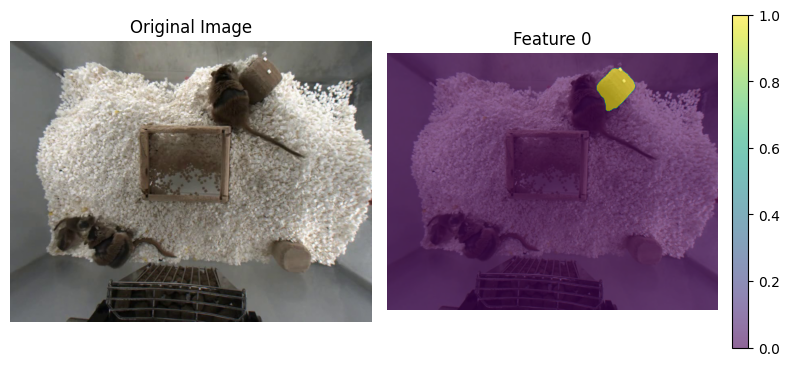

In [135]:
fig = plot.plot_features_over_image(image_for_plot, masks[2, ...].unsqueeze(0))

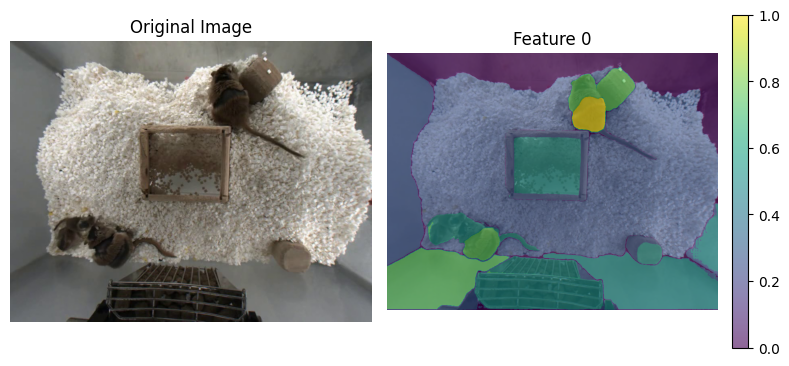

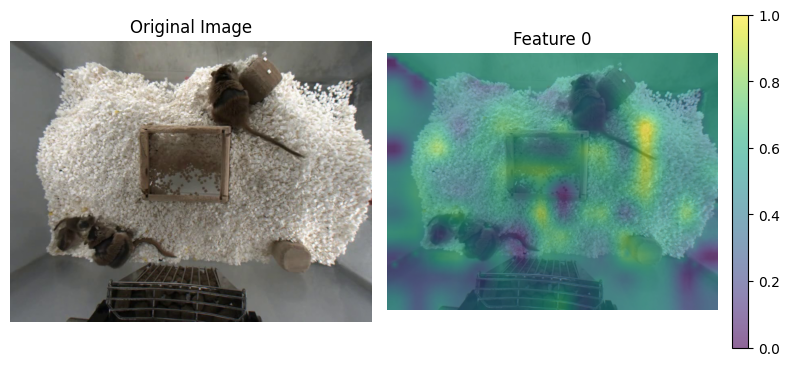

In [62]:
# Aggregate mask-wise features
image_for_plot = image[:, :, ::-1]
fig = plot.plot_features_over_image(image_for_plot, masks.sum(0).unsqueeze(0))
fig = plot.plot_features_over_image(image_for_plot, features.mean(0).unsqueeze(0))

### Test grounding dino

In [44]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline

#### Plot utils

#### Utils

Grounded Segment Anything (SAM)
Now it's time to define the Grounded SAM approach!

The approach is very simple:

use Grounding DINO to detect a given set of texts in the image. The output is a set of bounding boxes.
prompt Segment Anything (SAM) with the bounding boxes, for which the model will output segmentation masks.

Load recognize anything

In [55]:
all_labels = []

for image in video_frames:
    image = Image.fromarray(image[:,:, ::-1])
    image_size = 384
    image.resize((image_size, image_size))
    image_input = transform(image).unsqueeze(0).to(device)

    labels = inference_ram(image_input, ram_model)
    labels = labels[0].replace(' | ', ',').split(',')

    labels = postproc_labels(labels)

    print (f"Found {len(labels)} labels")
    print (labels)

    all_labels.extend(labels)

Found 13 labels
['animal', 'toy', 'grain', 'rodent', 'crate', 'pillow', 'mouse', 'pet', 'sparrow', 'hamster', 'house', 'bird', 'cage']
Found 12 labels
['make', 'animal', 'toy', 'grain', 'material', 'pillow', 'mouse', 'hamster', 'house', 'bird', 'miniature', 'cage']
Found 11 labels
['animal', 'toy', 'grain', 'rodent', 'crate', 'mousetrap', 'pillow', 'mouse', 'hamster', 'miniature', 'cage']
Found 13 labels
['animal', 'toy', 'grain', 'rodent', 'crate', 'pillow', 'hamster', 'mouse', 'pet', 'dog', 'house', 'bird', 'cage']
Found 12 labels
['animal', 'grain', 'rodent', 'crate', 'hamster', 'mouse', 'pet', 'sparrow', 'dog', 'house', 'bird', 'cage']
Found 11 labels
['animal', 'grain', 'rodent', 'hamster', 'mouse', 'pet', 'sparrow', 'dog', 'house', 'bird', 'cage']
Found 11 labels
['animal', 'grain', 'rodent', 'white', 'mouse', 'pet', 'sparrow', 'hamster', 'house', 'bird', 'cage']
Found 14 labels
['make', 'animal', 'toy', 'grain', 'white', 'material', 'pillow', 'mouse', 'snail', 'hamster', 'house'

In [ ]:
label_threshold = 0.5

unique_labels, counts = np.unique(all_labels, return_counts=True)
keep_labels = (counts / len(video_frames)) >= label_threshold
labels = unique_labels[keep_labels]
print (labels)

['animal' 'bird' 'cage' 'hamster' 'house' 'pillow' 'toy']


In [63]:
#Sourced from https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Grounding%20DINO/GroundingDINO_with_Segment_Anything.ipynb
plot_detections(image, detections)

NameError: name 'plot_detections' is not defined

In [36]:
image_array, detections = grounded_segmentation(
    image=image,
    labels=labels,
    threshold=0.4,
    polygon_refinement=False,
    detector_id=detector_id,
    segmenter_id=segmenter_id
)

Device set to use cuda


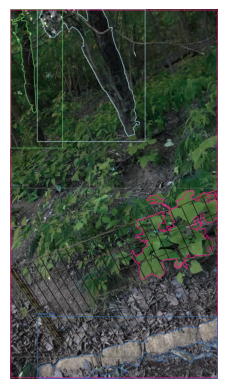

In [67]:
#Sourced from https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Grounding%20DINO/GroundingDINO_with_Segment_Anything.ipynb
gseg.plot_detections(image, detections)